# Lunar Lander with REINFORCE algorithm

This week I'm recycling quite a lot of code. Both from previous weeks, and from Colin Skow's code for a different environment ([here](https://github.com/colinskow/move37/blob/master/pg/cartpole_pg.py)).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gym
import ptan

from tqdm import tqdm
import pickle

from collections import deque

import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

np.random.seed(1)
device = torch.device('cuda')

In [3]:
ENV = gym.make('LunarLander-v2')
NS = ENV.observation_space.shape[0]  
NA = 1
LR = 1e-4
BATCH_SIZE = 4*1024
ENTROPY_BETA = 1e-3
EPISODE_NUM = 1e5
TARGET_REWARD = 190
GAMMA = 0.99

In [4]:
ENV.reset()

array([ 0.00177326,  1.4144524 ,  0.17960814,  0.15698475, -0.00204809,
       -0.04068395,  0.        ,  0.        ], dtype=float32)

## Create Random Agent

In [5]:
class RandomAgent():
    
    def __init__(self, env, clip_reward = False):
        self.env = env
        self.max_rounds = int(1e4)
        self.clip_reward = clip_reward
        self.n = 0  # Number of exploration rounds
        
    def randomAction(self):
        return self.env.action_space.sample()
    
    def pi(self, state):
        return self.randomAction()
    
    def playPol(self, save_frames = False, save_ext = 'tmp/experiment0/'):
        
        '''Plays a game from start to finish. '''
        
        reward = 0
        
        if save_frames:
            env = wrappers.Monitor(self.env, save_ext, force=True)
        else:
            env = self.env
            
        state= env.reset()
        
        self.history = deque()
        for i in range(self.max_rounds):
            if save_frames: env.render()
            action = self.pi(state)
            newstate, r, done, _ = self.env.step(action)
            self.history.append((state, action, r, done, newstate))
            if self.clip_reward:
                r = max(min(r, 1), -1)
            reward += r
            if done: break
                
        if save_frames: 
            env.close(); self.env.close()
        return reward

In [6]:
random_guy = RandomAgent(ENV)

In [7]:
random_guy.playPol()

-106.06439916393064

## Buffer for Storing Mean Rewards

In [8]:
class MeanBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.deque = deque(maxlen=capacity)
        self.sum = 0.0

    def add(self, val):
        if len(self.deque) == self.capacity:
            self.sum -= self.deque[0]
        self.deque.append(val)
        self.sum += val

    def mean(self):
        if not self.deque:
            return 0.0
        return self.sum / len(self.deque)

## Create Neural Architecture

In [9]:
arch = nn.Sequential(nn.Linear(8, 50), 
                    nn.ReLU(), 
                    nn.BatchNorm1d(50), 
                    nn.Linear(50, 4) )           

In [10]:
state = torch.tensor(ENV.reset()[None])
arch.eval()
with torch.no_grad():
    print(arch(state).numpy()[0])

[-0.12293397 -0.03991827  0.21742089  0.09919161]


## Define Agent

In [11]:
def softmax(x):
    ex = np.exp(x)
    return ex / np.sum(ex)

In [12]:
class Policy_Agent(RandomAgent):
    
    def __init__(self, env, arch):
        super().__init__(env)
        self.arch = arch
        
    def pi(self, state):
        return np.random.choice(4, 1, True, p = self.getProbs(state))[0]
        
    def getProbs(self, state):
        return softmax(self.getNetOutput(state))
    
    def getNetOutput(self, state):
        self.arch.eval()
        with torch.no_grad():
            inp = torch.tensor(state[None])
            return self.arch(inp).numpy()[0]

In [13]:
policy_guy = Policy_Agent(ENV, arch)

In [14]:
policy_guy.playPol()

-295.17288927132694

## Try out ptan

Never used this library before. Let's try it.

In [15]:
agent = ptan.agent.PolicyAgent(arch.cuda(), preprocessor=ptan.agent.float32_preprocessor, 
                               apply_softmax=True, device='cuda')

In [16]:
exp_source = ptan.experience.ExperienceSourceFirstLast(ENV, agent, gamma=GAMMA, steps_count=10)

In [17]:
ex = next(iter(exp_source))
ex

ExperienceFirstLast(state=array([-0.00663586,  1.4062669 , -0.6721725 , -0.20683655,  0.00769627,
        0.15225719,  0.        ,  0.        ], dtype=float32), action=3, reward=-5.394842106346405, last_state=array([-0.07160082,  1.3394413 , -0.6724851 , -0.33141997,  0.07319133,
        0.11004923,  0.        ,  0.        ], dtype=float32))

Okay, so it seems this library just feeds us the state, action, reward tuples we need.

## Optimize

In [18]:
def run_avg(x, beta = 0.95, bias_correct = True):
    '''Calculates exponential running average of x.'''
    r = 0; res = np.zeros(len(x))
    for i in range(len(x)):
        r = beta*r + (1-beta)*x[i]
        res[i] = r
    if bias_correct:
        res = res / (1 - beta **(np.arange(len(x))+1))
    return res

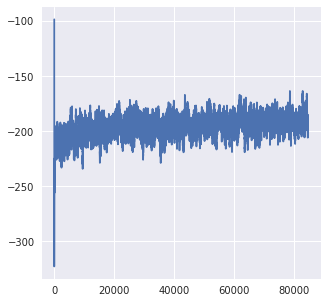

In [ ]:
optimizer = optim.Adam(arch.parameters(), lr=LR)

total_rewards = []
step_rewards = []
baseline_buf = MeanBuffer(50000)
step_idx = 0
done_episodes = 0
batch_states, batch_actions, batch_scales = [], [], []

for step_idx, exp in enumerate(exp_source):
    
    baseline_buf.add(exp.reward)
    baseline = baseline_buf.mean()
    
    batch_states.append(exp.state)
    batch_actions.append(int(exp.action))
    batch_scales.append(exp.reward - baseline)

    # handle when an episode is completed
    episode_rewards = exp_source.pop_total_rewards()
    if episode_rewards:
        done_episodes += 1
        reward = episode_rewards[0]
        total_rewards.append(reward)
        mean_rewards = float(np.mean(total_rewards[-100:]))
        if done_episodes % 100 == 0:
            f, ax = plt.subplots(figsize=(5, 5))
            ax.plot(run_avg(total_rewards, 0.99), '-')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        if done_episodes >= EPISODE_NUM:
            break
        if mean_rewards > TARGET_REWARD:
            print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
            break

    if len(batch_states) < BATCH_SIZE:
        continue
        
    # copy training data to the GPU
    states_v = torch.FloatTensor(batch_states).to(device)[range(BATCH_SIZE), :]
    batch_actions_t = torch.LongTensor(batch_actions).to(device)[range(BATCH_SIZE)]
    batch_scale_v = torch.FloatTensor(batch_scales).to(device)[range(BATCH_SIZE)]

    # apply gradient descent
    optimizer.zero_grad()
    logits_v = arch(states_v)
    # apply the softmax and take the logarithm in one step, more precise
    log_prob_v = F.log_softmax(logits_v, dim=1)
    # scale the log probs according to (reward - baseline)
    log_prob_actions_v = log_prob_v[:, batch_actions_t]
    # take the mean cross-entropy across all batches
    loss_policy_v = -log_prob_actions_v.mean()

    # subtract the entropy bonus from the loss function
    prob_v = F.softmax(logits_v, dim=1)
    entropy_v = -(prob_v * log_prob_v).sum(dim=1).mean()
    entropy_loss_v = -ENTROPY_BETA * entropy_v
    loss_v = loss_policy_v + entropy_loss_v

    loss_v.backward()
    optimizer.step()

    batch_states.clear()
    batch_actions.clear()
    batch_scales.clear()

## Save/Load Parameters, Play Game

In [ ]:
pickle.dump(arch, open('tmp/lunar_lander_arch.pickle', 'wb'))

In [ ]:
arch = pickle.load(open('tmp/lunar_lander_arch.pickle', 'rb'))

In [ ]:
policy_guy = Policy_Agent(ENV, arch.to(torch.device('cpu')))

In [ ]:
policy_guy.playPol()